GIVEN NEW UNSEEN DATA, THIS NOTEBOOK WILL EVALUATE THE MODELS PERFORMANCE

    - Provide confusion matrix
    - output FNs and FPs

In [80]:
from torchvision.models import mobilenet_v3_large
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import torch
import torchvision
from classifier import ImageClassifier

In [83]:
transform = transforms.Compose([transforms.Resize(size=(224,224)),
        transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

no_normalization = transforms.Compose([transforms.Resize(size=(224,224)),
        transforms.ToTensor()])

In [90]:
data_path = ".\\7.25_test_data\\"

dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

un_aug_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=no_normalization
)

dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

119


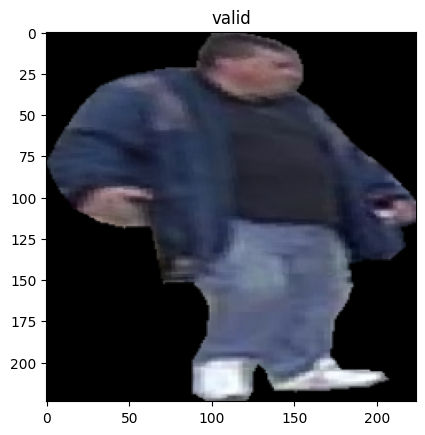

In [91]:
classes = dataset.classes

# Visualize the data
idx = torch.randint(len(un_aug_dataset), size=(1,)).item()
image, lbl = un_aug_dataset[idx]
plt.imshow(image.permute(1,2,0))
plt.title(f'{classes[lbl]}')
plt.show()

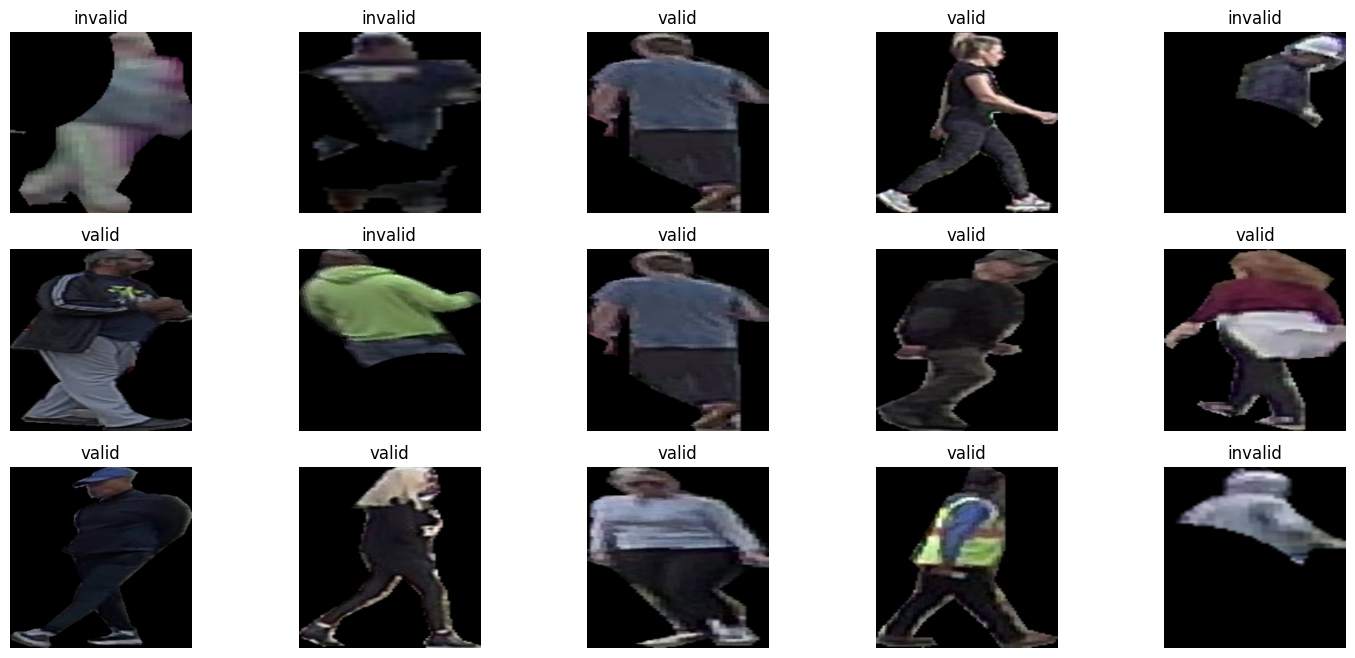

In [92]:
# visualize dataset with no normalization
classes = dataset.classes
figure = plt.figure(figsize=(18, 8))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(un_aug_dataset), size=(1,)).item()
    img, label = un_aug_dataset[sample_idx]
    # while label == 1:
    #     sample_idx = torch.randint(len(dataset), size=(1,)).item()
    #     img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0).squeeze())
plt.show()

In [93]:
model = mobilenet_v3_large()

modules = list(model.children())[:-1]  # delete the last fc layer.
model = nn.Sequential(*modules)

model.classifier = nn.Sequential(nn.Flatten(),
                                nn.Linear(960, 4096),
                                nn.ReLU(),
                                nn.Linear(4096, 4096),
                                nn.ReLU(),
                                nn.Linear(4096, 1000),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(1000, 2),
                                nn.Softmax(dim=1)
                            )

In [118]:
# Load the model
classifier = ImageClassifier(model=model, learning_rate= 0.00001, num_classes=2)
trainer = pl.Trainer(gpus=0, fast_dev_run=True, inference_mode=False)

ckpt_path = "best_acc_epoch=144-val_acc=0.90.ckpt"
trainer.test(model=classifier, dataloaders=dataloader, ckpt_path=ckpt_path)

best_model = ImageClassifier.load_from_checkpoint(checkpoint_path=ckpt_path, model=model)

c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerat

Testing DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


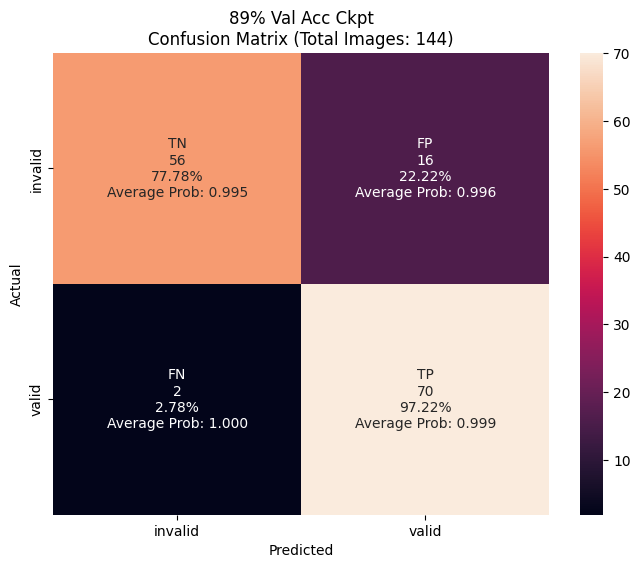

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

pred = []
gt = []
prob_list = []
tn_prob = []
fp_prob = []
fn_prob = []
tp_prob = []

# iterate over the test dataset
for images, labels in dataloader:
    # images, labels = images.cuda(), labels.cuda()
    best_model.eval()
    
    with torch.no_grad():
        output = best_model(images)
    
    # get the probability of prediction
    prob_tensor = output
    prob = prob_tensor.detach().cpu().numpy()
    
    for probability in prob:
        prob_list.append(probability.max())

    # Convert output to predictions
    output = np.argmax(output.detach().cpu().numpy(), axis=1)
    pred.extend(output)
    
    labels = labels.cpu().numpy()
    gt.extend(labels)
    
    for idx, guess in enumerate(pred):
        label = gt[idx]

        # TN
        if (guess == 0 and label == 0):
            tn_prob.append(prob_list[idx])
        # FP
        elif (guess  == 1 and label == 0):
            fp_prob.append(prob_list[idx])
        # FN
        elif (guess  == 0 and label == 1):
            fn_prob.append(prob_list[idx])
        # TP
        elif (guess  == 1 and label == 1):
            tp_prob.append(prob_list[idx])

tn_avg = np.average(tn_prob)
fp_avg = np.average(fp_prob)
fn_avg = np.average(fn_prob)
tp_avg = np.average(tp_prob)

group_avg_prob = [tn_avg, fp_avg, fn_avg, tp_avg]

classes = ['invalid', 'valid']

# Build confusion matrix
cf_matrix = confusion_matrix(gt, pred)

# Calculate group counts and percentages
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

# calculating accuracy ex: TN / (TN+FP)
group_prob = np.zeros((2,2))
total = np.sum(cf_matrix, axis=1)
group_prob[0] = (cf_matrix[0] / total[0])*100
group_prob[1] = (cf_matrix[1] / total[1])*100
group_prob = group_prob.reshape(4)

labels = [f"{v1}\n{v2}\n{v3:.2f}%\nAverage Prob: {v4.max():.3f}" for v1, v2, v3, v4 in zip(group_names, group_counts, list(group_prob), group_avg_prob)]
labels = np.asarray(labels).reshape(2, 2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=classes, yticklabels=classes)

plt.title(f'Confusion Matrix (Total Images: {np.sum(cf_matrix)})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [120]:
from sklearn.metrics import accuracy_score
scikit_acc = accuracy_score(gt, pred)
print(scikit_acc)

0.875


In [121]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

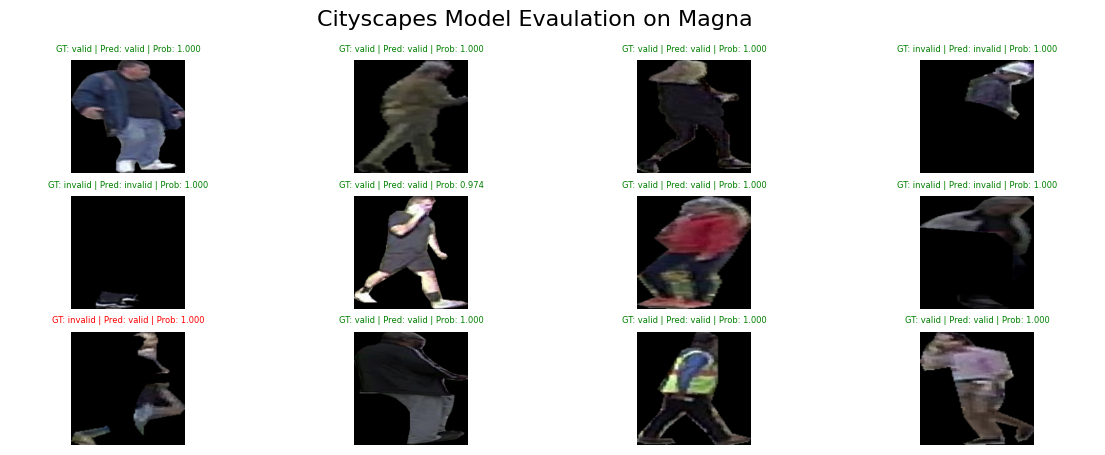

In [122]:
device = "cuda" if torch.cuda.is_available() else "cpu"

import random
random.randint(0,10000000000000000000000000)
samples = random.sample(range(len(dataset)), 12)
class_names = ['invalid', 'valid']

figure = plt.figure(figsize=(14, 5))
cols, rows = 4, 3
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# no normalization
for i in range(1, cols * rows + 1):
    img, gt = dataset[samples[i-1]]

    best_model.eval()
    with torch.inference_mode():
      transformed_image = img.unsqueeze(dim=0)
      target_image_pred = best_model(transformed_image)#.to(device))

    target_image_pred_probs = target_image_pred
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    color = "green" if gt == target_image_pred_label else "red"
    params = {"color" : color}
    
    unorm(img)         
    plt.axis("off")
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.imshow(img.permute(1,2,0).squeeze())
    plt.title(f"GT: {class_names[gt]} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}", fontdict=params, fontsize=6)
    plt.axis("off")
    
    figure.suptitle('Cityscapes Model Evaulation on Magna', fontsize=16)
    

---- 92: 1 0 ----
---- 129: 1 0 ----


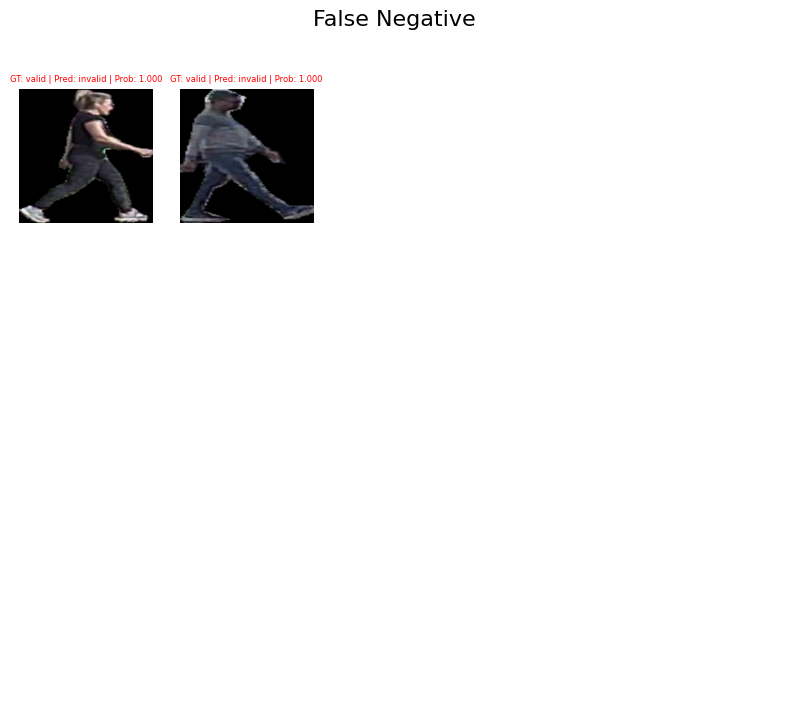

In [123]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 4
i = 0
while i < len(fn_prob):
  for sample_idx in range(len(dataset)):
    img, label = dataset[sample_idx]
    best_model.eval()
      
    with torch.inference_mode():
      transformed_image = img.unsqueeze(dim=0)
      target_image_pred = best_model(transformed_image)#.to(device))
      target_image_pred_label = torch.argmax(target_image_pred, dim=1)
      
    if(target_image_pred_label.item() == 0 and label == 1) and (i < len(fn_prob)):
      i += 1
      color = "green" if label == target_image_pred_label else "red"
      params = {"color" : color}
      unorm(img)         
      plt.axis("off")
      figure.add_subplot(rows, cols, i)
      plt.title(classes[label])
      plt.imshow(img.permute(1,2,0).squeeze())
      plt.title(f"GT: {class_names[label]} | Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred.max():.3f}", fontdict=params, fontsize=6)
      plt.axis("off")
      print(f'---- {sample_idx}: {label} {target_image_pred_label.item()} ----')
  
  
      
figure.suptitle('False Negative', fontsize=16)
plt.show()

---- 10: 0 1 ----
---- 29: 0 1 ----
---- 41: 0 1 ----
---- 43: 0 1 ----
---- 44: 0 1 ----
---- 46: 0 1 ----
---- 47: 0 1 ----
---- 49: 0 1 ----
---- 51: 0 1 ----
---- 53: 0 1 ----
---- 54: 0 1 ----
---- 56: 0 1 ----
---- 59: 0 1 ----
---- 61: 0 1 ----
---- 62: 0 1 ----
---- 67: 0 1 ----


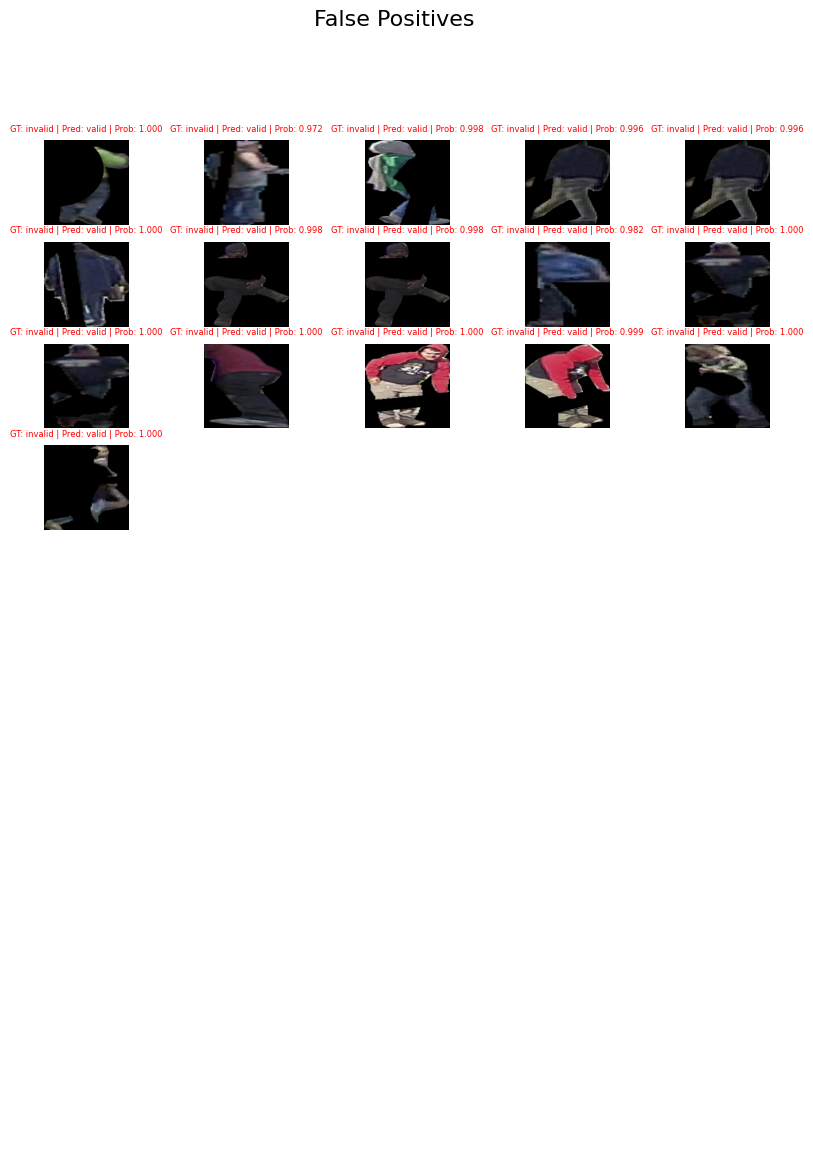

In [124]:
figure1 = plt.figure(figsize=(10,13))
cols, rows = 5, 10
i = 0
while i < len(fp_prob):
  for sample_idx in range(len(dataset)):
    img, label = dataset[sample_idx]
    best_model.eval()
      
    with torch.inference_mode():
      transformed_image = img.unsqueeze(dim=0)
      target_image_pred = best_model(transformed_image)#.to(device))
      target_image_pred_label = torch.argmax(target_image_pred, dim=1)
      
    if(target_image_pred_label.item() == 1 and label == 0) and (i < len(fp_prob)):
      i += 1
      color = "green" if label == target_image_pred_label else "red"
      params = {"color" : color}
      unorm(img)         
      plt.axis("off")
      figure1.add_subplot(rows, cols, i)
      plt.title(classes[label])
      plt.imshow(img.permute(1,2,0).squeeze())
      plt.title(f"GT: {class_names[label]} | Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred.max():.3f}", fontdict=params, fontsize=6)
      plt.axis("off")
      print(f'---- {sample_idx}: {label} {target_image_pred_label.item()} ----')
      
figure1.suptitle('False Positives', fontsize=16)
plt.show()